In [113]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import datetime
import scipy.stats as stats
from scipy import sparse
import scikitplot as skplt
import seaborn as sns
import feature_engine.imputation as mdi
from feature_engine.outliers import Winsorizer
import statsmodels.api as sm
import xgboost as xgb
from sklearn import preprocessing, metrics, linear_model,svm
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV, train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import mutual_info_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import itertools

In [2]:
os.chdir('/home/hanif/dataset/home')
train_data = pd.read_csv('application_train.csv')
test_data = pd.read_csv('application_test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [5]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


In [6]:
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_data.shape

(307511, 122)

In [8]:
train_data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [9]:
train_data.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [10]:
category = list(train_data.dtypes[train_data.dtypes == 'object'].index)
category

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [11]:
for col in train_data.columns:
    print(col)
    print(train_data[col].head())
    print()

SK_ID_CURR
0    100002
1    100003
2    100004
3    100006
4    100007
Name: SK_ID_CURR, dtype: int64

TARGET
0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

NAME_CONTRACT_TYPE
0         Cash loans
1         Cash loans
2    Revolving loans
3         Cash loans
4         Cash loans
Name: NAME_CONTRACT_TYPE, dtype: object

CODE_GENDER
0    M
1    F
2    M
3    F
4    M
Name: CODE_GENDER, dtype: object

FLAG_OWN_CAR
0    N
1    N
2    Y
3    N
4    N
Name: FLAG_OWN_CAR, dtype: object

FLAG_OWN_REALTY
0    Y
1    N
2    Y
3    Y
4    Y
Name: FLAG_OWN_REALTY, dtype: object

CNT_CHILDREN
0    0
1    0
2    0
3    0
4    0
Name: CNT_CHILDREN, dtype: int64

AMT_INCOME_TOTAL
0    202500.0
1    270000.0
2     67500.0
3    135000.0
4    121500.0
Name: AMT_INCOME_TOTAL, dtype: float64

AMT_CREDIT
0     406597.5
1    1293502.5
2     135000.0
3     312682.5
4     513000.0
Name: AMT_CREDIT, dtype: float64

AMT_ANNUITY
0    24700.5
1    35698.5
2     6750.0
3    29686.5
4    21865.5
Nam

In [12]:
train_data.NAME_CONTRACT_TYPE.unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

In [13]:
train_data['TARGET'].value_counts().to_frame()

,TARGET
0,282686
1,24825


In [14]:
train_data.columns = train_data.columns.str.lower()

In [15]:
test_data.columns = test_data.columns.str.lower()

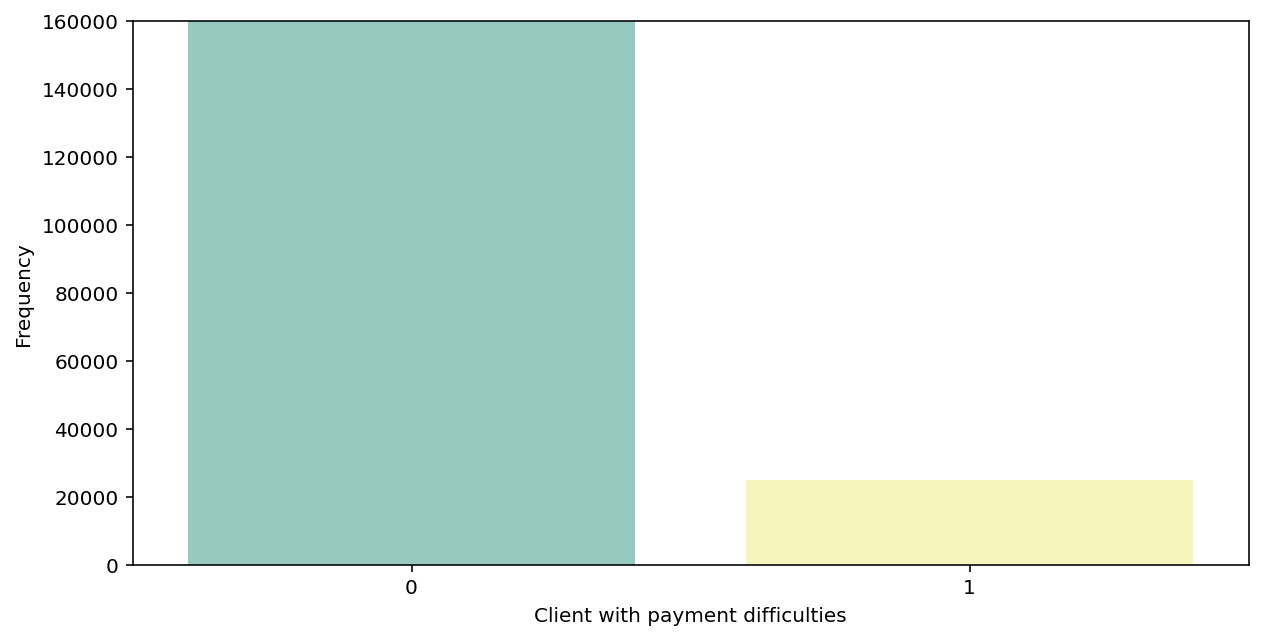

In [16]:
ax = sns.countplot(x = train_data.target ,palette="Set3")
sns.set(font_scale=1.5)
ax.set_ylim(top = 150000)
ax.set_xlabel('Client with payment difficulties')
ax.set_ylabel('Frequency')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=160000)

plt.show()

<AxesSubplot:xlabel='amt_credit', ylabel='Count'>

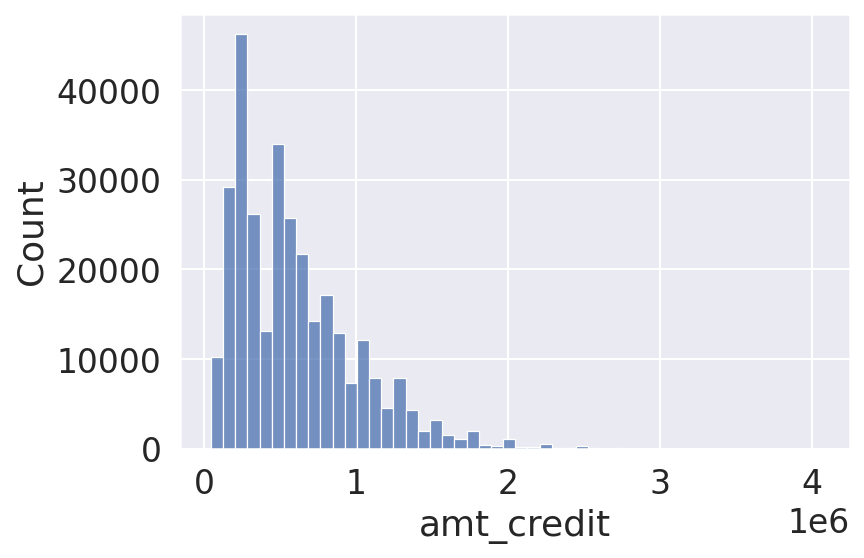

In [17]:
sns.histplot(train_data.amt_credit, bins=50)

<AxesSubplot:xlabel='amt_credit', ylabel='Count'>

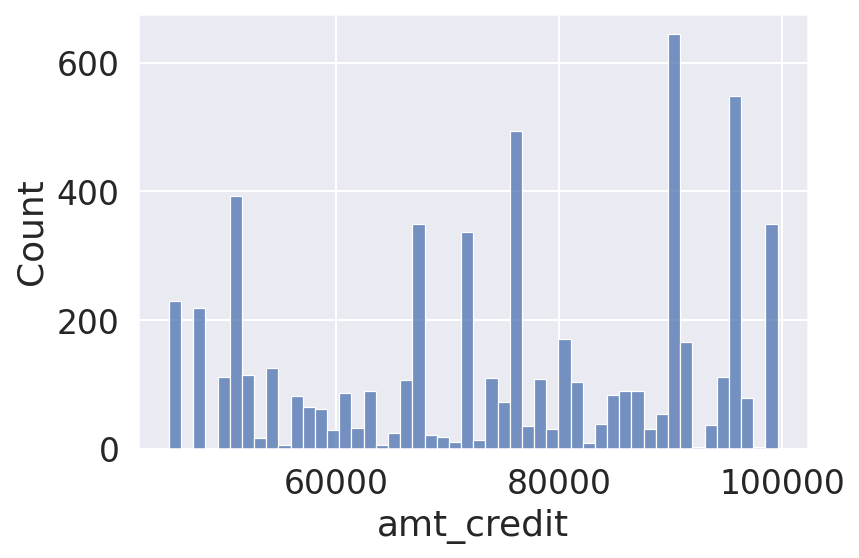

In [18]:
sns.histplot(train_data.amt_credit[train_data.amt_credit < 100000], bins=50)

In [19]:
train_data[train_data.columns[train_data.isnull().any()]].isnull().sum()

amt_annuity                       12
amt_goods_price                  278
name_type_suite                 1292
own_car_age                   202929
occupation_type                96391
                               ...  
amt_req_credit_bureau_day      41519
amt_req_credit_bureau_week     41519
amt_req_credit_bureau_mon      41519
amt_req_credit_bureau_qrt      41519
amt_req_credit_bureau_year     41519
Length: 67, dtype: int64

In [20]:
test_data[test_data.columns[test_data.isnull().any()]].isnull().sum()

amt_annuity                      24
name_type_suite                 911
own_car_age                   32312
occupation_type               15605
ext_source_1                  20532
                              ...  
amt_req_credit_bureau_day      6049
amt_req_credit_bureau_week     6049
amt_req_credit_bureau_mon      6049
amt_req_credit_bureau_qrt      6049
amt_req_credit_bureau_year     6049
Length: 64, dtype: int64

In [21]:
#summing missing value trainset
nan_train = train_data.isnull().sum().sort_values(ascending = False).head(20).reset_index().sort_values(0,ascending=False)
nan_train.columns = ['variable','total_nan']
nan_train = nan_train[nan_train['total_nan'] > 0]#select only has nan value variable
#geting list that has variable nan
list_nan_train = nan_train['variable'].values.tolist()
list_nan_train

['commonarea_medi',
 'commonarea_mode',
 'commonarea_avg',
 'nonlivingapartments_mode',
 'nonlivingapartments_medi',
 'nonlivingapartments_avg',
 'fondkapremont_mode',
 'livingapartments_medi',
 'livingapartments_mode',
 'livingapartments_avg',
 'floorsmin_avg',
 'floorsmin_medi',
 'floorsmin_mode',
 'years_build_medi',
 'years_build_avg',
 'years_build_mode',
 'own_car_age',
 'landarea_mode',
 'landarea_avg',
 'landarea_medi']

In [22]:
#sum nan in test
nan_test = test_data.isnull().sum().sort_values(ascending = False).head(35).reset_index().sort_values(0,ascending=False)
nan_test.columns = ['variable','total_nan']
nan_test = nan_test[nan_test['total_nan'] > 0] #select only has nan value variable
#geting list that has variable nan
list_nan_test = nan_test['variable'].values.tolist()
list_nan_test

['commonarea_medi',
 'commonarea_mode',
 'commonarea_avg',
 'nonlivingapartments_mode',
 'nonlivingapartments_medi',
 'nonlivingapartments_avg',
 'fondkapremont_mode',
 'livingapartments_avg',
 'livingapartments_medi',
 'livingapartments_mode',
 'floorsmin_medi',
 'floorsmin_mode',
 'floorsmin_avg',
 'own_car_age',
 'years_build_medi',
 'years_build_mode',
 'years_build_avg',
 'landarea_medi',
 'landarea_avg',
 'landarea_mode',
 'basementarea_avg',
 'basementarea_mode',
 'basementarea_medi',
 'nonlivingarea_mode',
 'nonlivingarea_avg',
 'nonlivingarea_medi',
 'elevators_avg',
 'elevators_medi',
 'elevators_mode',
 'wallsmaterial_mode',
 'apartments_avg',
 'apartments_medi',
 'apartments_mode',
 'housetype_mode',
 'entrances_medi']

In [23]:
#seeing type datasets of train type in nan variable
nan_train['percentage %'] = nan_train['total_nan']/len(train_data)
print('Total missing values in trainsets:')
nan_train

Total missing values in trainsets:


,variable,total_nan,percentage %
0,commonarea_medi,214865,0.698723
2,commonarea_mode,214865,0.698723
1,commonarea_avg,214865,0.698723
3,nonlivingapartments_mode,213514,0.694330
4,nonlivingapartments_medi,213514,0.694330
5,nonlivingapartments_avg,213514,0.694330
6,fondkapremont_mode,210295,0.683862
7,livingapartments_medi,210199,0.683550
8,livingapartments_mode,210199,0.683550
9,livingapartments_avg,210199,0.683550


In [24]:
#seeing type datasets of train type in nan variable
nan_test['percentage %'] = nan_test['total_nan']/len(test_data)
print('Total missing values in testset:')
nan_test

Total missing values in testset:


,variable,total_nan,percentage %
0,commonarea_medi,33495,0.687161
2,commonarea_mode,33495,0.687161
1,commonarea_avg,33495,0.687161
3,nonlivingapartments_mode,33347,0.684125
4,nonlivingapartments_medi,33347,0.684125
5,nonlivingapartments_avg,33347,0.684125
6,fondkapremont_mode,32797,0.672842
7,livingapartments_avg,32780,0.672493
8,livingapartments_medi,32780,0.672493
9,livingapartments_mode,32780,0.672493


In [25]:
clean_train = train_data.dropna(thresh = 10000,axis=1)

In [26]:
clean_test = test_data.dropna(thresh = 10000,axis=1)

In [27]:
# train
numeric_train = clean_train.dtypes[clean_train.dtypes != 'object'].index
numeric_train = numeric_train.drop("target")
# test
numeric_test = test_data.dtypes[test_data.dtypes != 'object'].index

In [29]:
category_train = clean_train.dtypes[clean_train.dtypes == 'object'].index

In [76]:
"""f = pd.melt(clean_train, value_vars=category_train)
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False, height=6)
g = g.map(sns.countplot, "value")
plt.show()"""

'f = pd.melt(clean_train, value_vars=category_train)\ng = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False, height=6)\ng = g.map(sns.countplot, "value")\nplt.show()'

In [31]:
# chosing numerical variable in test
numeric_test = clean_test.describe().columns.values.tolist()
clean_test[numeric_test] = clean_test[numeric_test].fillna(clean_test[numeric_test].mode().iloc[0])
#categorical testset NaN
category_nan = [s for s in clean_test if s not in numeric_test]
clean_test[category_nan] = clean_test[category_nan].fillna(clean_test[category_nan].mode().iloc[0])
print("the column has 106") 
clean_test.shape
clean_train.describe()

the column has 106


,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [32]:
int_var_train = train_data.describe().columns.values.tolist()

In [33]:
# handling numeric variable that has Nan with median
clean_train[int_var_train] = train_data[int_var_train].fillna(train_data[int_var_train].median())
#handling categorical
list_category = [s for s in clean_train if s not in int_var_train]
clean_train[list_category] = train_data[list_category].fillna(train_data[list_category].mode().iloc[0])
clean_train.isnull().sum().sort_values()

sk_id_curr                    0
totalarea_mode                0
housetype_mode                0
fondkapremont_mode            0
nonlivingarea_medi            0
                             ..
reg_region_not_live_region    0
hour_appr_process_start       0
weekday_appr_process_start    0
region_rating_client          0
amt_req_credit_bureau_year    0
Length: 122, dtype: int64

In [34]:
clean_test.isnull().sum().sort_values()

sk_id_curr                      0
totalarea_mode                  0
housetype_mode                  0
fondkapremont_mode              0
nonlivingarea_medi              0
                               ..
reg_region_not_live_region      0
hour_appr_process_start         0
weekday_appr_process_start      0
years_beginexpluatation_mode    0
amt_req_credit_bureau_year      0
Length: 121, dtype: int64

In [36]:
categorical_train = clean_train.select_dtypes(include='object')
numerical_train = clean_train.select_dtypes(exclude='object')

In [37]:
categorical_train

,name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,occupation_type,weekday_appr_process_start,organization_type,fondkapremont_mode,housetype_mode,wallsmaterial_mode,emergencystate_mode
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,reg oper account,block of flats,Panel,No
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,reg oper account,block of flats,Panel,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services,reg oper account,block of flats,"Stone, brick",No
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,Laborers,MONDAY,XNA,reg oper account,block of flats,"Stone, brick",No
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,THURSDAY,School,reg oper account,block of flats,Panel,No
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,reg oper account,block of flats,"Stone, brick",No


In [38]:
numerical_train

,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
#categorical_train = pd.DataFrame(categorical_train)

In [40]:
numerical_train.corrwith(clean_train.target).to_frame('correlation')

,correlation
sk_id_curr,-0.002108
target,1.000000
cnt_children,0.019187
amt_income_total,-0.003982
amt_credit,-0.030369
...,...
amt_req_credit_bureau_day,0.001701
amt_req_credit_bureau_week,-0.001306
amt_req_credit_bureau_mon,-0.014794
amt_req_credit_bureau_qrt,-0.005833


In [41]:
def calculate_mi(series):
    return mutual_info_score(series, clean_train.target)

df_mi = categorical_train.apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

display(df_mi.head())
display(df_mi.tail())

,MI
organization_type,0.002668
name_income_type,0.002114
occupation_type,0.001856
name_education_type,0.001796
code_gender,0.001452


,MI
name_type_suite,0.000052
weekday_appr_process_start,0.000025
flag_own_realty,0.000019
housetype_mode,0.000014
emergencystate_mode,0.000011


In [42]:
def calculate_mi(series):
    return mutual_info_score(series, clean_train.target)
mi = categorical_train.apply(calculate_mi)
mi.sort_values(ascending=False)

organization_type             0.002668
name_income_type              0.002114
occupation_type               0.001856
name_education_type           0.001796
code_gender                   0.001452
name_family_status            0.000809
name_housing_type             0.000613
name_contract_type            0.000528
flag_own_car                  0.000243
wallsmaterial_mode            0.000195
fondkapremont_mode            0.000146
name_type_suite               0.000052
weekday_appr_process_start    0.000025
flag_own_realty               0.000019
housetype_mode                0.000014
emergencystate_mode           0.000011
dtype: float64

In [43]:
global_mean = clean_train.target.mean()
global_mean

0.08072881945686496

In [44]:
for col in categorical_train:
    df_group = train_data.groupby(by=col).target.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
name_contract_type,,,
Cash loans,0.083459,0.002730,1.033821
Revolving loans,0.054783,-0.025946,0.678609


,mean,diff,risk
code_gender,,,
F,0.069993,-0.010736,0.867017
M,0.101419,0.020690,1.256295
XNA,0.000000,-0.080729,0.000000


,mean,diff,risk
flag_own_car,,,
N,0.085002,0.004273,1.052936
Y,0.072437,-0.008292,0.897292


,mean,diff,risk
flag_own_realty,,,
N,0.083249,0.002520,1.031221
Y,0.079616,-0.001113,0.986213


,mean,diff,risk
name_type_suite,,,
Children,0.073768,-0.006961,0.913775
Family,0.074946,-0.005783,0.928365
Group of people,0.084871,0.004142,1.051308
Other_A,0.087760,0.007031,1.087094
Other_B,0.098305,0.017576,1.217720
"Spouse, partner",0.078716,-0.002013,0.975066
Unaccompanied,0.081830,0.001102,1.013646


,mean,diff,risk
name_income_type,,,
Businessman,0.000000,-0.080729,0.000000
Commercial associate,0.074843,-0.005886,0.927086
Maternity leave,0.400000,0.319271,4.954860
Pensioner,0.053864,-0.026865,0.667217
State servant,0.057550,-0.023179,0.712876
Student,0.000000,-0.080729,0.000000
Unemployed,0.363636,0.282908,4.504418
Working,0.095885,0.015156,1.187738


,mean,diff,risk
name_education_type,,,
Academic degree,0.018293,-0.062436,0.226594
Higher education,0.053551,-0.027178,0.663346
Incomplete higher,0.084850,0.004121,1.051046
Lower secondary,0.109277,0.028548,1.353627
Secondary / secondary special,0.089399,0.008670,1.107402


,mean,diff,risk
name_family_status,,,
Civil marriage,0.099446,0.018717,1.231851
Married,0.075599,-0.005130,0.936452
Separated,0.081942,0.001214,1.015032
Single / not married,0.098077,0.017348,1.214891
Unknown,0.000000,-0.080729,0.000000
Widow,0.058242,-0.022487,0.721454


,mean,diff,risk
name_housing_type,,,
Co-op apartment,0.079323,-0.001406,0.982581
House / apartment,0.077957,-0.002772,0.965666
Municipal apartment,0.085397,0.004669,1.057831
Office apartment,0.065724,-0.015005,0.814134
Rented apartment,0.123131,0.042402,1.525236
With parents,0.116981,0.036252,1.449063


,mean,diff,risk
occupation_type,,,
Accountants,0.048303,-0.032426,0.598340
Cleaning staff,0.096067,0.015338,1.189997
Cooking staff,0.104440,0.023711,1.293713
Core staff,0.063040,-0.017689,0.780880
Drivers,0.113261,0.032532,1.402985
HR staff,0.063943,-0.016786,0.792074
High skill tech staff,0.061599,-0.019130,0.763040
IT staff,0.064639,-0.016090,0.800690
Laborers,0.105788,0.025059,1.310408


,mean,diff,risk
weekday_appr_process_start,,,
FRIDAY,0.081469,0.000740,1.009172
MONDAY,0.077572,-0.003157,0.960899
SATURDAY,0.078873,-0.001856,0.977008
SUNDAY,0.079291,-0.001438,0.982184
THURSDAY,0.081003,0.000274,1.003391
TUESDAY,0.083505,0.002776,1.034388
WEDNESDAY,0.081604,0.000875,1.010836


,mean,diff,risk
organization_type,,,
Advertising,0.081585,0.000856,1.010607
Agriculture,0.104727,0.023998,1.297269
Bank,0.051855,-0.028874,0.642333
Business Entity Type 1,0.081384,0.000655,1.008112
Business Entity Type 2,0.085284,0.004555,1.056423
Business Entity Type 3,0.092996,0.012267,1.151958
Cleaning,0.111538,0.030810,1.381644
Construction,0.116798,0.036069,1.446796
Culture,0.055409,-0.025320,0.686359


,mean,diff,risk
fondkapremont_mode,,,
not specified,0.075435,-0.005294,0.934427
org spec account,0.058195,-0.022533,0.720875
reg oper account,0.069782,-0.010947,0.864399
reg oper spec account,0.065563,-0.015166,0.812138


,mean,diff,risk
housetype_mode,,,
block of flats,0.069434,-0.011295,0.860087
specific housing,0.101401,0.020672,1.256069
terraced house,0.084983,0.004255,1.052703


,mean,diff,risk
wallsmaterial_mode,,,
Block,0.070247,-0.010481,0.870166
Mixed,0.075348,-0.005380,0.933352
Monolithic,0.047218,-0.033511,0.584891
Others,0.083077,0.002348,1.029086
Panel,0.063477,-0.017252,0.786295
"Stone, brick",0.074057,-0.006672,0.917354
Wooden,0.096979,0.016250,1.201290


,mean,diff,risk
emergencystate_mode,,,
No,0.069649,-0.011080,0.862753
Yes,0.095790,0.015062,1.186570


In [45]:
clean_train.organization_type.value_counts()

Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

In [46]:
clean_train.code_gender.value_counts()

F      202448
M      105059
XNA         4
Name: code_gender, dtype: int64

In [90]:
clean_train.corr()

,sk_id_curr,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
sk_id_curr,1.000000,-0.002108,-0.001129,-0.001820,-0.000343,-0.000431,-0.000258,0.000849,-0.001500,0.001366,...,0.000509,0.000167,0.001073,0.000282,-0.002517,-0.002066,0.001879,0.000328,0.000809,0.004071
target,-0.002108,1.000000,0.019187,-0.003982,-0.030369,-0.012815,-0.039623,-0.037227,0.078239,-0.044932,...,-0.007952,-0.001358,0.000215,0.003709,-0.000074,0.001701,-0.001306,-0.014794,-0.005833,0.012161
cnt_children,-0.001129,0.019187,1.000000,0.012882,0.002145,0.021377,-0.001856,-0.025573,0.330938,-0.239818,...,0.004031,0.000864,0.000988,-0.002450,0.000159,0.000107,-0.001083,-0.007983,-0.004913,-0.034874
amt_income_total,-0.001820,-0.003982,0.012882,1.000000,0.156870,0.191657,0.159632,0.074796,0.027261,-0.064223,...,0.003130,0.002408,0.000242,-0.000589,0.001432,0.003481,0.003950,0.026746,0.007924,0.015821
amt_credit,-0.000343,-0.030369,0.002145,0.156870,1.000000,0.770127,0.986734,0.099738,-0.055436,-0.066838,...,0.034329,0.021082,0.031023,-0.016148,-0.002366,0.005028,0.001634,0.055536,0.020379,-0.036634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
amt_req_credit_bureau_day,-0.002066,0.001701,0.000107,0.003481,0.005028,0.002286,0.005442,0.001160,0.001018,0.000309,...,0.012956,0.001154,0.000078,-0.001076,0.230873,1.000000,0.218370,-0.002750,-0.001551,0.000742
amt_req_credit_bureau_week,0.001879,-0.001306,-0.001083,0.003950,0.001634,0.013494,0.001880,-0.002335,-0.004014,0.002505,...,-0.003666,-0.001006,-0.001239,-0.000057,0.006422,0.218370,1.000000,-0.007423,-0.007466,0.029318
amt_req_credit_bureau_mon,0.000328,-0.014794,-0.007983,0.026746,0.055536,0.037171,0.057337,0.071630,-0.003580,-0.032416,...,-0.000179,-0.002230,0.002177,-0.003489,0.002973,-0.002750,-0.007423,1.000000,0.005318,0.013708
amt_req_credit_bureau_qrt,0.000809,-0.005833,-0.004913,0.007924,0.020379,0.010685,0.020811,-0.001873,-0.016281,0.013466,...,-0.003362,-0.001079,0.000034,-0.002066,0.000725,-0.001551,-0.007466,0.005318,1.000000,0.095723


/home/hanif/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


"sns.scatterplot(\n    data=clean_train, x=x, y=y, hue=None, size=None,\n    sizes=(500, 200), size_order=(500, 200), legend='full'\n)"

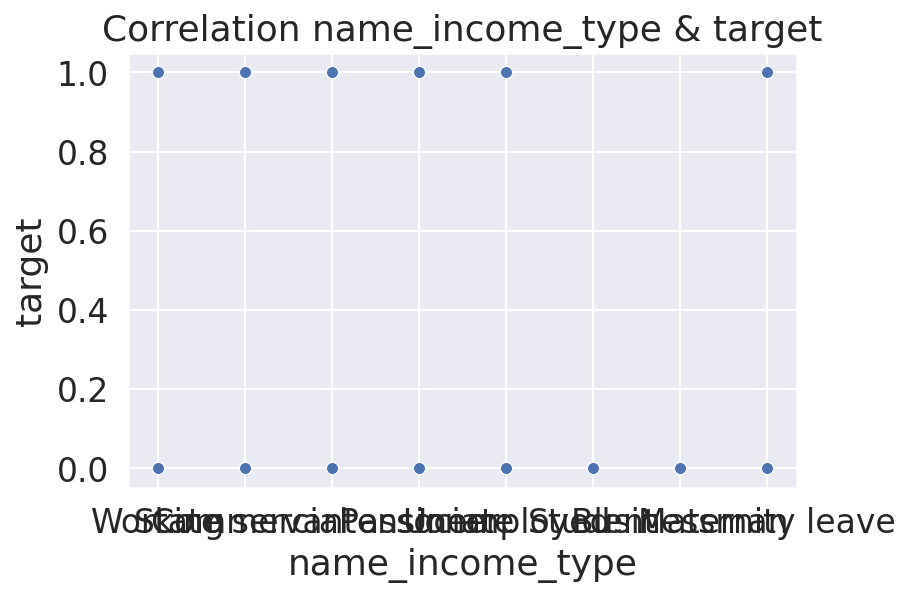

In [48]:
# scatter plot 
x = clean_train['name_income_type']
y = clean_train['target']

sns.scatterplot(x,y)
plt.title('Correlation name_income_type & target')
plt.savefig('cor.png')
"""sns.scatterplot(
    data=clean_train, x=x, y=y, hue=None, size=None,
    sizes=(500, 200), size_order=(500, 200), legend='full'
)"""

In [49]:
clean_train[['target','name_income_type']]

,target,name_income_type
0,1,Working
1,0,State servant
2,0,Working
3,0,Working
4,0,Working
...,...,...
307506,0,Working
307507,0,Pensioner
307508,0,Working
307509,1,Commercial associate


In [50]:
#remove duplicate
cleaning_train = clean_train[~clean_train['sk_id_curr'].duplicated()]
cleaning_test = clean_test[~clean_test['sk_id_curr'].duplicated()]

print("train_data",train_data.shape)
print("test_data",test_data.shape)
train_data = pd.get_dummies(cleaning_train)
test_data = pd.get_dummies(cleaning_test)

train_data (307511, 122)
test_data (48744, 121)


In [51]:
# equalize shape reduce column in train
col_traint = train_data.columns.tolist()
col_test = test_data.columns.tolist()
to_drop = [s for s in col_traint if s not in col_test]
to_drop

['target',
 'code_gender_XNA',
 'name_income_type_Maternity leave',
 'name_family_status_Unknown']

In [81]:
# spliting X and y in data train
X = train_data.drop(to_drop,axis=1)
X = X.drop('sk_id_curr',axis=1)
y = train_data['target']

X_train, X_test, y_train,y_test = train_test_split(X, y, test_size =0.25,random_state = 100)

In [82]:
X_train.shape

(230633, 241)

In [83]:
X_train.head()

,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,...,housetype_mode_terraced house,wallsmaterial_mode_Block,wallsmaterial_mode_Mixed,wallsmaterial_mode_Monolithic,wallsmaterial_mode_Others,wallsmaterial_mode_Panel,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Wooden,emergencystate_mode_No,emergencystate_mode_Yes
99761,0,112500.0,276408.0,16830.0,198000.0,0.018634,-10098,-2735,-10082.0,-2779,...,0,0,0,0,0,1,0,0,1,0
109374,0,117000.0,942300.0,30397.5,675000.0,0.025164,-14231,-3367,-3977.0,-4899,...,0,0,0,0,0,1,0,0,1,0
71531,0,135000.0,373311.0,19188.0,283500.0,0.024610,-10247,-321,-4714.0,-2887,...,0,0,0,0,0,1,0,0,1,0
136777,1,315000.0,1256400.0,36864.0,900000.0,0.018801,-13097,-4943,-1187.0,-4443,...,0,0,0,0,0,0,1,0,1,0
283781,0,180000.0,900000.0,38263.5,900000.0,0.028663,-20107,-8040,-8277.0,-3649,...,0,0,0,0,0,1,0,0,1,0


In [84]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<h1>RF</h1>

In [85]:
#Apply undersampling
rus = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [56]:
rf_model = RandomForestClassifier()
rf_model.fit(X_resampled,y_resampled)

RandomForestClassifier()

In [57]:
y_pred = rf_model.predict(X_test)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

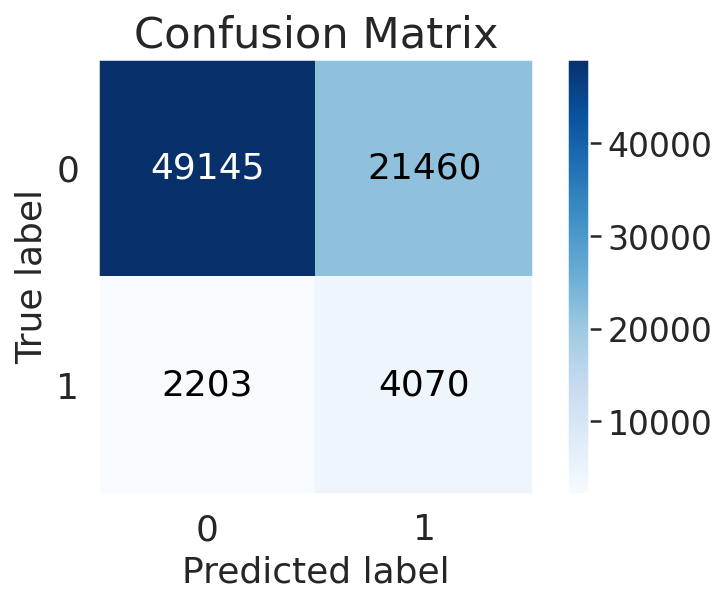

In [58]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

In [59]:
print(classification_report(y_test,y_pred))
print('ROC-AUC:',round(roc_auc_score(y_test,y_pred),4))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     70605
           1       0.16      0.65      0.26      6273

    accuracy                           0.69     76878
   macro avg       0.56      0.67      0.53     76878
weighted avg       0.89      0.69      0.76     76878

ROC-AUC: 0.6724


In [60]:
# Create a StratifiedKFold instance with 10 splits, to be used in cross validation and (later on GridSearch)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)
acc = cross_val_score(rf_model, X_resampled, y_resampled, cv=cv, scoring='accuracy', n_jobs=-1)
recall = cross_val_score(rf_model, X_resampled, y_resampled, cv=cv, scoring='recall', n_jobs=-1)
precision = cross_val_score(rf_model, X_resampled, y_resampled, cv=cv, scoring='average_precision', n_jobs=-1)
f1_score =  cross_val_score(rf_model, X_resampled, y_resampled, cv=cv, scoring='f1', n_jobs=-1)
roc_auc =  cross_val_score(rf_model, X_resampled, y_resampled, cv=cv, scoring='roc_auc', n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (acc.mean(), acc.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
print("F1-Score: %0.2f (+/- %0.2f)" % (f1_score.mean(), f1_score.std() * 2))
print("ROC_AUC: %0.2f (+/- %0.2f)" % (roc_auc.mean(), roc_auc.std() * 2))

Accuracy: 0.67 (+/- 0.02)
Recall: 0.65 (+/- 0.02)
Precision: 0.71 (+/- 0.02)
F1-Score: 0.66 (+/- 0.01)
ROC_AUC: 0.73 (+/- 0.02)


In [61]:
# # Fit the random search model
rf = RandomForestRegressor(n_estimators = 81, random_state = 2, max_features = 'log2')
rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('mean target:', clean_train['target'].mean())
rmse_RF = np.sqrt(metrics.mean_squared_error(y_test, y_pred))/clean_train['target'].mean()
rmse_RF

Mean Absolute Error: 0.3077993704310726
Mean Squared Error: 0.3077993704310726
Root Mean Squared Error: 0.5547966928804394
mean target: 0.08072881945686496


6.872349882149318

<h1>Hyperparameters Tuning</h1>

In [70]:
parameter_space = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'n_estimators': [25, 50, 100, 200, 300, 1000]  
}

model = xgb.XGBClassifier(objective="binary:logistic", verbose=None, seed=1121218)
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],  # Fix subsample
    "colsample_bytree": [0.5],  # Fix colsample_bytree
}
# Grid Search Implementation
clf = HalvingGridSearchCV(model, param_grid, scoring="roc_auc", 
                          n_jobs=-1, min_resources="exhaust", factor=3)

# Fit the model
clf.fit(X_train, y_train)

clf.best_params_

/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: 

[08:29:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:29:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:30:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:30:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: 

[08:45:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:46:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:46:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:47:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: 

[09:05:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:05:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:06:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:06:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: 

[09:27:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:27:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:28:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:28:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: 

[09:45:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:46:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:47:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:48:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: 

[10:13:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:14:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:15:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:16:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/hanif/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:52:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'max_depth': 3,
 'reg_lambda': 10,
 'scale_pos_weight': 1,
 'subsample': 0.8}

In [71]:
clf_results = pd.concat([pd.DataFrame(clf.cv_results_["params"]), 
                         pd.DataFrame(clf.cv_results_["mean_test_score"], 
                                      columns=["F1 Score"])],axis=1)

# Sort the values according to the accuracy
clf_results.sort_values(by = ["F1 Score"], ascending = False).head(5) 

,colsample_bytree,gamma,max_depth,reg_lambda,scale_pos_weight,subsample,F1 Score
160,0.5,0.25,3,10,1,0.8,0.754306
161,0.5,0.00,3,10,1,0.8,0.754306
157,0.5,0.00,3,10,1,0.8,0.741136
158,0.5,0.25,3,10,1,0.8,0.740980
159,0.5,1.00,3,10,1,0.8,0.740613


In [72]:
RF_best_parameters = RandomForestClassifier(bootstrap = True,
                                            max_depth = 100,
                                            n_estimators = 100).fit(X_resampled, y_resampled)

<h1>Model Evaluation</h1>

In [73]:
y_pred = RF_best_parameters.predict(X_test)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

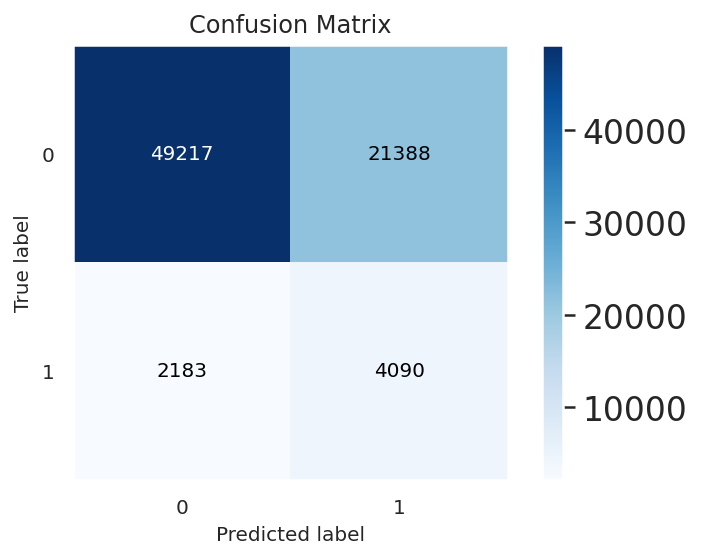

In [79]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

In [80]:
print(classification_report(y_test,y_pred))
print('ROC-AUC:',round(roc_auc_score(y_test,y_pred),4))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     70605
           1       0.16      0.65      0.26      6273

    accuracy                           0.69     76878
   macro avg       0.56      0.67      0.53     76878
weighted avg       0.89      0.69      0.76     76878

ROC-AUC: 0.6745


<h1>LR</h1>

In [105]:
def calculation(clean_train, target, bins=10):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = clean_train.columns
    
    for ivars in cols[~cols.isin([target])]:
        if (clean_train[ivars].dtype.kind in "bifc") and (len(np.unique(clean_train[ivars]))>10):
            binned_x = pd.qcut(clean_train[ivars], bins,  duplicates="drop")
            d0 = pd.DataFrame({"x": binned_x, "y": clean_train[target]})
        else:
            d0 = pd.DataFrame({'x': clean_train[ivars], "y": clean_train[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ["Cutoff", "N", "Events"]
        d["% of Events"] = np.maximum(d["Events"], 0.5) / d["Events"].sum()
        d['Non-Events'] = d["N"] - d["Events"]
        d["% of Non-Events"] = np.maximum(d["Non-Events"], 0.5) / d["Non-Events"].sum()
        d["WoE"] = np.log(d["% of Events"]/d["% of Non-Events"])
        d["IV"] = d["WoE"] * (d["% of Events"] - d["% of Non-Events"])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d["IV"].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d["IV"].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

In [106]:
calculation(clean_train,'target', bins=10)

Information value of sk_id_curr is 0.000287
Information value of name_contract_type is 0.015039
Information value of code_gender is 0.038599
Information value of flag_own_car is 0.006597
Information value of flag_own_realty is 0.000505
Information value of cnt_children is 0.001669
Information value of amt_income_total is 0.010758
Information value of amt_credit is 0.045073
Information value of amt_annuity is 0.026589
Information value of amt_goods_price is 0.091552
Information value of name_type_suite is 0.001402
Information value of name_income_type is 0.058381
Information value of name_education_type is 0.050836
Information value of name_family_status is 0.021711
Information value of name_housing_type is 0.01573
Information value of region_population_relative is 0.035094
Information value of days_birth is 0.0842
Information value of days_employed is 0.101263
Information value of days_registration is 0.026872
Information value of days_id_publish is 0.038453
Information value of own_ca

In [107]:
features = ['days_employed', 'ext_source_1', 'ext_source_2', 'ext_source_3']

In [108]:
#Assigning data to variables in the model
X = clean_train[features]
y = clean_train['target']

In [110]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)
print("Training dataset shape:", X_train.shape, y_train.shape)
print("Testing dataset shape:", X_test.shape, y_test.shape)

Training dataset shape: (230633, 4) (230633,)
Testing dataset shape: (76878, 4) (76878,)


In [114]:
#Function to build and evaluate the first logistic regression model
def evaluation__model(features, plots):
    model = sm.Logit(y_train, X_train[features]).fit(disp = 0)
    pre = model.predict(X_test[features])
    fpr, tpr, thresholds = roc_curve(y_test, pre)
    pre_train = model.predict(X_train[features])
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pre_train)
    gini_score = 2 * auc(fpr, tpr) - 1
    gini_score_train = 2 * auc(fpr_train, tpr_train) - 1
    #Comparison of results - test and train dataset
    print("Test dataset")
    print("Gini score: {}".format(round(gini_score,2)))
    print("AUC: {}".format(round(auc(fpr, tpr),2)))
    print("Number of features: {}".format(len(features)))
    print("*"*40)
    print("Train dataset")
    print("Gini score: {}".format(round(gini_score_train,2)))
    print("AUC: {}".format(round(auc(fpr_train, tpr_train),2)))
    print("Number of features: {}".format(len(features)))
    
    if plots == True:
        #ROC curve - comparison
        #test dataset
        plt.style.use("grayscale")
        plt.figure(figsize=(20,5))
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=None)
        #lw = 2
        plt.subplot(1,2,1)
        plt.plot(fpr,
                 tpr,
                 color="black",
                 #lw=lw,
                 label="AUC = %0.2f" % auc(fpr, tpr))
        plt.plot([0, 1], [0, 1], "r--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title("Test dataset - Receiver Operating Characteristic", fontsize=25)
        plt.xticks(fontsize= 15)
        plt.yticks(fontsize=15)
        plt.xlabel("False Positive Rate", fontsize=18)
        plt.ylabel("True Positive Rate", fontsize=18)
        plt.legend(loc=4,
                   prop={"size": 16},
                   title="Area Under Curve",
                   title_fontsize="17",
                   frameon=True)
        #train dataset
        pre_train = model.predict(X_train[features])
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pre_train)
        plt.subplot(1,2,2)
        plt.plot(fpr_train,
                 tpr_train,
                 color="black",
                 #lw=lw,
                 label="AUC = %0.2f" % auc(fpr_train, tpr_train))
        plt.plot([0, 1], [0, 1], "r--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title("Train dataset - Receiver Operating Characteristic", fontsize=25)
        plt.xticks(fontsize= 15)
        plt.yticks(fontsize=15)
        plt.xlabel("False Positive Rate", fontsize=18)
        plt.ylabel("True Positive Rate", fontsize=18)
        plt.legend(loc=4,
                   prop={"size": 16},
                   title="Area Under Curve",
                   title_fontsize="17",
                   frameon=True)
        plt.show()
 
    
    return gini_score, model

Test dataset
Gini score: 0.44
AUC: 0.72
Number of features: 4
****************************************
Train dataset
Gini score: 0.43
AUC: 0.72
Number of features: 4


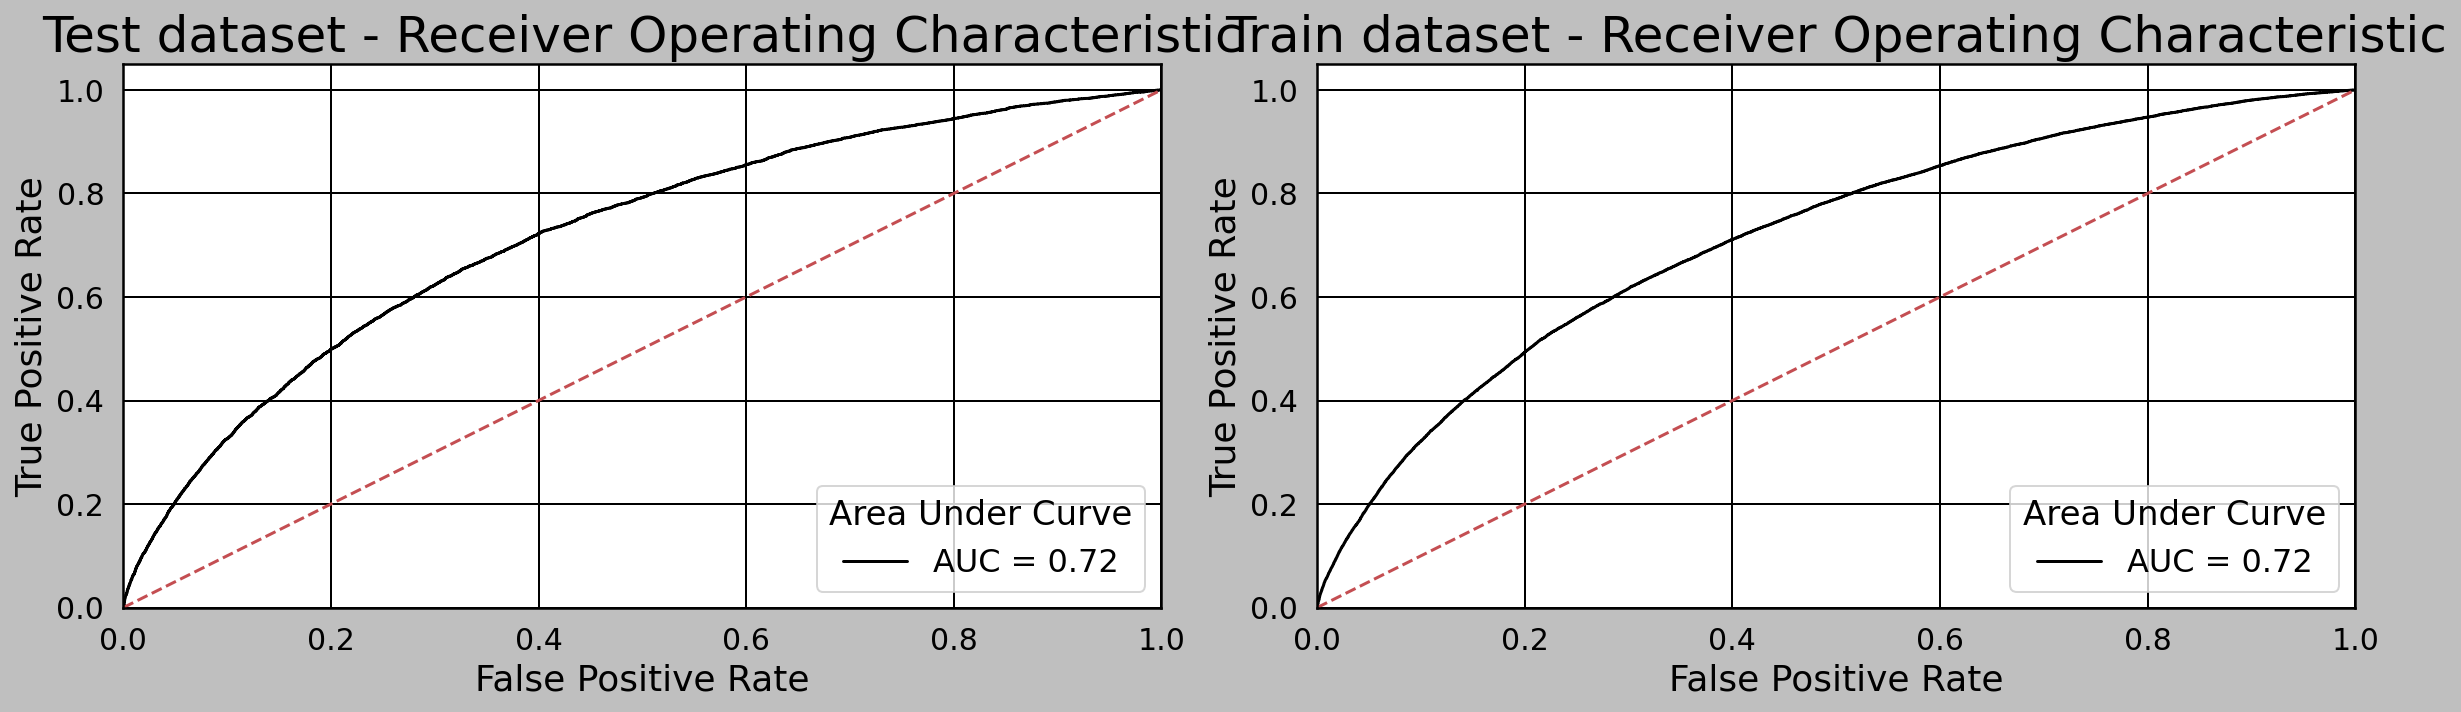

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               230633
Model:                          Logit   Df Residuals:                   230629
Method:                           MLE   Df Model:                            3
Date:                Thu, 29 Sep 2022   Pseudo R-squ.:                 0.08016
Time:                        14:39:54   Log-Likelihood:                -59517.
converged:                       True   LL-Null:                       -64704.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
days_employed  -8.95e-07    6.5e-08    -13.765      0.000   -1.02e-06   -7.68e-07
ext_source_1     -0.7656      0.042    -18.122      0.000      -0.848      -0.683
ext_source_2     -2.1041      0.036    -

In [115]:
#Model quality verification
score, model = evaluation__model(features, True)
print(model.summary())

In [128]:
model = sm.Logit(y_train, X_train[features]).fit(disp = 0)

In [129]:
#Preditions of the model
predict = model.predict(X_test)
predict_train = model.predict(X_test)

In [130]:
print(classification_report(y_test, predict.round()))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70672
           1       0.00      0.00      0.00      6206

    accuracy                           0.92     76878
   macro avg       0.46      0.50      0.48     76878
weighted avg       0.85      0.92      0.88     76878



In [133]:
#Gini and AUC from test and train dataset
pre = model.predict(X_test[features])
fpr, tpr, thresholds = roc_curve(y_test, pre)
gini_score = 2 * auc(fpr, tpr) - 1

pre_train = model.predict(X_train[features])
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pre_train)
gini_score_train = 2 * auc(fpr_train, tpr_train) - 1

#Gini and AUC for test dataset
gini_test_1 = gini_score.round(2)
AUC_test_1 = auc(fpr, tpr).round(2)

#Gini and AUC for training dataset
gini_train_1 = gini_score_train.round(2)
AUC_train_1 = auc(fpr_train, tpr_train).round(2)

In [134]:
#Data Frame with comparison of results on test and train datasets
mcomparison_test_train_model_1 =pd.DataFrame({"dataset": ["test", "train"],
                                              "AUC"    : [AUC_test_1, AUC_train_1],
                                              "Gini"   : [gini_test_1, gini_train_1]}).set_index("dataset")
mcomparison_test_train_model_1

,AUC,Gini
dataset,,
test,0.72,0.44
train,0.72,0.43


In [135]:
#Odds Ratio
print(np.exp(model.params))

days_employed    0.999999
ext_source_1     0.465068
ext_source_2     0.121959
ext_source_3     0.114325
dtype: float64


In [136]:
#Odds Ratio to interpretation
round((np.exp(model.params)-1)*100,2)

days_employed    -0.00
ext_source_1    -53.49
ext_source_2    -87.80
ext_source_3    -88.57
dtype: float64

In [137]:
#Marginal Effects Computation 
#overall - the average of teh marginal effects at each observation
#dydx - no transformation is made and marginal effects are returned
marginal_effects = model.get_margeff(at="overall", method="dydx")
print(marginal_effects.summary())

        Logit Marginal Effects       
Dep. Variable:                 target
Method:                          dydx
At:                           overall
                   dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
days_employed -6.188e-08   4.51e-09    -13.732      0.000   -7.07e-08    -5.3e-08
ext_source_1     -0.0529      0.003    -18.264      0.000      -0.059      -0.047
ext_source_2     -0.1455      0.002    -58.411      0.000      -0.150      -0.141
ext_source_3     -0.1499      0.003    -56.341      0.000      -0.155      -0.145


In [138]:
x = dt.datetime.now()
print(x) 

2022-09-29 15:12:08.585575
